# 필요한 라이브러리 설치 및 import

In [ ]:
!pip3 install torchsummary
!pip3 install imageio


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\ygeun\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from torchsummary import summary

In [7]:
# Function to set the seed for reproducibility
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # The below two lines are for deterministic algorithm behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed()

# 데이터셋 준비

In [8]:
# DataLoader for MNIST
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize(28),
                       transforms.ToTensor(),
                       transforms.Normalize([0.5], [0.5])  # Normalize to range [-1, 1]
                   ])),
    batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 987kB/s] 


Extracting ./data/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 158kB/s]


Extracting ./data/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 983kB/s] 


Extracting ./data/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.26MB/s]

Extracting ./data/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/mnist\MNIST\raw



# 모델 구성

In [9]:
class Generator(nn.Module):
    """
    Generator class for GAN.
    Takes a latent vector (size 100) as input and produces an image (size 784, i.e., 28x28) as output.
    Aims to generate fake images indistinguishable from real MNIST digits.
    """
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28*1),
            nn.Tanh(),  # -1, 1 값으로 제한
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)  # (batch_size, 1, 28, 28)로 reshpae

In [10]:
class Discriminator(nn.Module):
    """
    Discriminator class for GAN.
    Takes an image (size 784, i.e., 28x28) as input and predicts whether the image is real or generated.
    Outputs a probability value between 0 and 1.
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28*1, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Sigmoid activation to output probabilities
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) # (batch_size, 28 * 28)
        return self.model(img_flat) # (batch_size): 진짜/가짜 판별 결과

In [11]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [12]:
summary(generator, input_size = (64, 100)) # (batch_size, latent_space)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 64, 128]          12,928
              ReLU-2              [-1, 64, 128]               0
            Linear-3              [-1, 64, 256]          33,024
              ReLU-4              [-1, 64, 256]               0
            Linear-5              [-1, 64, 512]         131,584
              ReLU-6              [-1, 64, 512]               0
            Linear-7              [-1, 64, 784]         402,192
              Tanh-8              [-1, 64, 784]               0
Total params: 579,728
Trainable params: 579,728
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 1.64
Params size (MB): 2.21
Estimated Total Size (MB): 3.88
----------------------------------------------------------------


In [13]:
summary(discriminator, input_size = (28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                    [-1, 1]             257
           Sigmoid-7                    [-1, 1]               0
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.04
Estimated Total Size (MB): 2.06
----------------------------------------------------------------


Loss Function 및 Optimizaer 정의

In [14]:
# Loss function
criterion = nn.BCELoss()

In [15]:
# Optimizers
# Learning rate 설정
learning_rate = 1e-4

optimizer_G = optim.Adam(generator.parameters(), lr = learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# 훈련 과정 정의

In [16]:
# Number of epochs
num_epochs = 10


# For visualizing the progress
fixed_noise = torch.randn(64, 100, device=device)

os.makedirs('./images', exist_ok=True)
os.makedirs('./results', exist_ok=True)

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        if epoch == 0 and i == 0:
            sample_real_images = real_images # to keep batch_size

        batch_size = real_images.size(0)

        # Real labels are 1, fake labels are 0
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator with real images
        discriminator.zero_grad()
        outputs = discriminator(real_images.to(device))
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Train Discriminator with fake images
        noise = torch.randn(batch_size, 100, device=device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize for discriminator
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize for generator
        g_loss.backward()
        optimizer_G.step()

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Save real images once for comparison
    if epoch == 0:
        save_image(sample_real_images, './images/real_images.png')

    # Save sampled images every epoch
    fake_images = generator(fixed_noise)
    save_image(fake_images, f'./images/fake_images_epoch_{epoch+1:04d}.png')

    # Save discriminator results for each image in the grid
    discriminator_results = discriminator(fake_images).cpu().detach().numpy().reshape(8, 8)
    np.save(f'./results/discriminator_outputs_epoch_{epoch+1:04d}.npy', discriminator_results)

print('Training finished.')

Epoch [1/10], Step [200/938], d_loss: 0.3623, g_loss: 1.4950, D(x): 0.96, D(G(z)): 0.27
Epoch [1/10], Step [400/938], d_loss: 0.2108, g_loss: 2.2893, D(x): 0.97, D(G(z)): 0.16
Epoch [1/10], Step [600/938], d_loss: 0.5021, g_loss: 2.2303, D(x): 0.87, D(G(z)): 0.27
Epoch [1/10], Step [800/938], d_loss: 0.1433, g_loss: 3.7863, D(x): 0.96, D(G(z)): 0.10
Epoch [2/10], Step [200/938], d_loss: 0.1524, g_loss: 3.6809, D(x): 0.95, D(G(z)): 0.09
Epoch [2/10], Step [400/938], d_loss: 0.3413, g_loss: 2.8436, D(x): 0.91, D(G(z)): 0.17
Epoch [2/10], Step [600/938], d_loss: 0.3409, g_loss: 3.2986, D(x): 0.92, D(G(z)): 0.16
Epoch [2/10], Step [800/938], d_loss: 0.5017, g_loss: 2.1013, D(x): 0.86, D(G(z)): 0.22
Epoch [3/10], Step [200/938], d_loss: 0.1605, g_loss: 4.7835, D(x): 0.92, D(G(z)): 0.02
Epoch [3/10], Step [400/938], d_loss: 0.1955, g_loss: 3.0019, D(x): 0.97, D(G(z)): 0.14
Epoch [3/10], Step [600/938], d_loss: 0.0932, g_loss: 4.5154, D(x): 0.98, D(G(z)): 0.06
Epoch [3/10], Step [800/938], d_

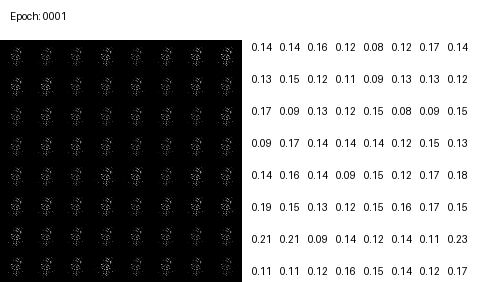

In [20]:
import os
import torch
import imageio
from PIL import Image, ImageDraw, ImageFont
import glob
import numpy as np

def create_gif_with_predictions(image_folder='./images', result_folder='./results', gif_name='CGAN_training_progress.gif', duration=200):
    images = []

    fns = glob.glob(os.path.join(image_folder, 'fake_images_epoch_*.png'))
    filenames = sorted(fns, key=lambda x: int(x.split('_')[-1].split('.')[0]))

    # Load default font
    font = ImageFont.load_default()

    for filename in filenames:
        epoch_number = filename.split('_')[-1].split('.')[0]
        image = Image.open(filename)
        result_filename = f'discriminator_outputs_epoch_{epoch_number}.npy'
        discriminator_outputs = np.load(os.path.join(result_folder, result_filename))

        new_image = Image.new('RGB', (image.width * 2, image.height + 40), 'white')
        new_image.paste(image, (0, 40))

        draw = ImageDraw.Draw(new_image)
        text_x = 10
        text_y = 10
        draw.text((text_x, text_y), f'Epoch: {epoch_number}', fill="black", font=font)

        for idx in range(8):
            for jdx in range(8):
                position = (image.width + 10 + jdx * 28, 40 + idx * 28 + 1 + idx * 4)
                text = f'{discriminator_outputs[idx, jdx]:.2f}'
                if discriminator_outputs[idx, jdx] > 0.5:
                    draw.text(position, text, fill="blue", font=font, stroke_fill="blue")
                else:
                    draw.text(position, text, fill="black", font=font)

        images.append(new_image)

    imageio.mimsave(gif_name, images, duration=duration / 1000.0)
    return gif_name

gif_fn = create_gif_with_predictions()

# Display the created GIF in Jupyter Notebook
from IPython.display import Image as IPImage, display
display(IPImage(filename=gif_fn))